1. Setup & Imports

In [2]:
!pip install scikit-learn joblib pyarrow fastparquet

import os, re, joblib, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler

warnings.filterwarnings("ignore")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.0 MB/s eta 0:00:00


2. Load Dataset

In [3]:
PROJECT_PATH = "/content/drive/MyDrive/player_value_prediction_project"
DATA_PATH = os.path.join(PROJECT_PATH, "data", "processed", "final_data_with_sentiment.csv")

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
df.head(3)


Dataset shape: (276823, 84)


,player_id,player_name,season,avg_market_value,max_market_value,min_market_value,n_valuations,num_transfers,avg_transfer_fee,last_transfer_fee,...,goals_per90,reddit_num_posts,reddit_num_comments_used,reddit_pos_ratio,reddit_neu_ratio,reddit_neg_ratio,reddit_mean_compound,reddit_fallback_used,reddit_subreddits_covered,sentiment_missing_flag
0,176850,A.J. Soares,2011,100000.0,100000.0,100000.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,1
1,176850,A.J. Soares,2012,175000.0,175000.0,175000.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,1
2,176850,A.J. Soares,2015,300000.0,300000.0,300000.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,1


3. Quick EDA (Exploratory Data Analysis)

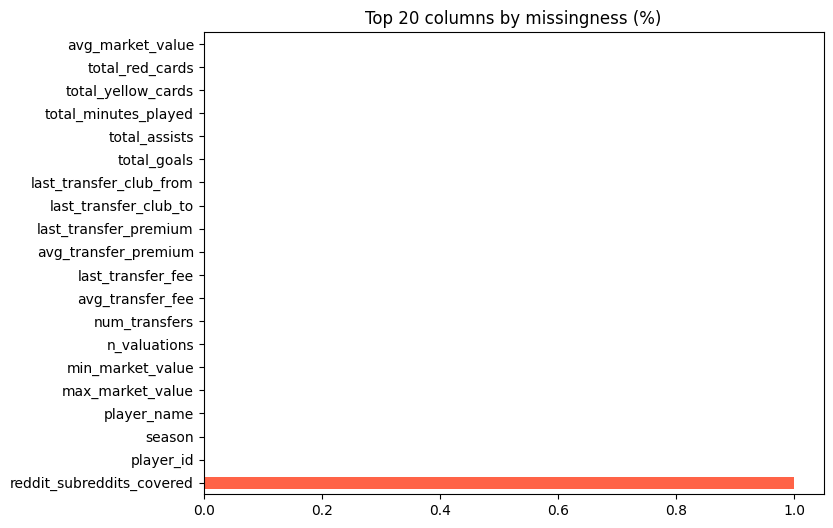

In [4]:
#Missingness

missing = df.isna().mean().sort_values(ascending=False)
plt.figure(figsize=(8,6))
missing.head(20).plot(kind="barh", color="tomato")
plt.title("Top 20 columns by missingness (%)")
plt.show()


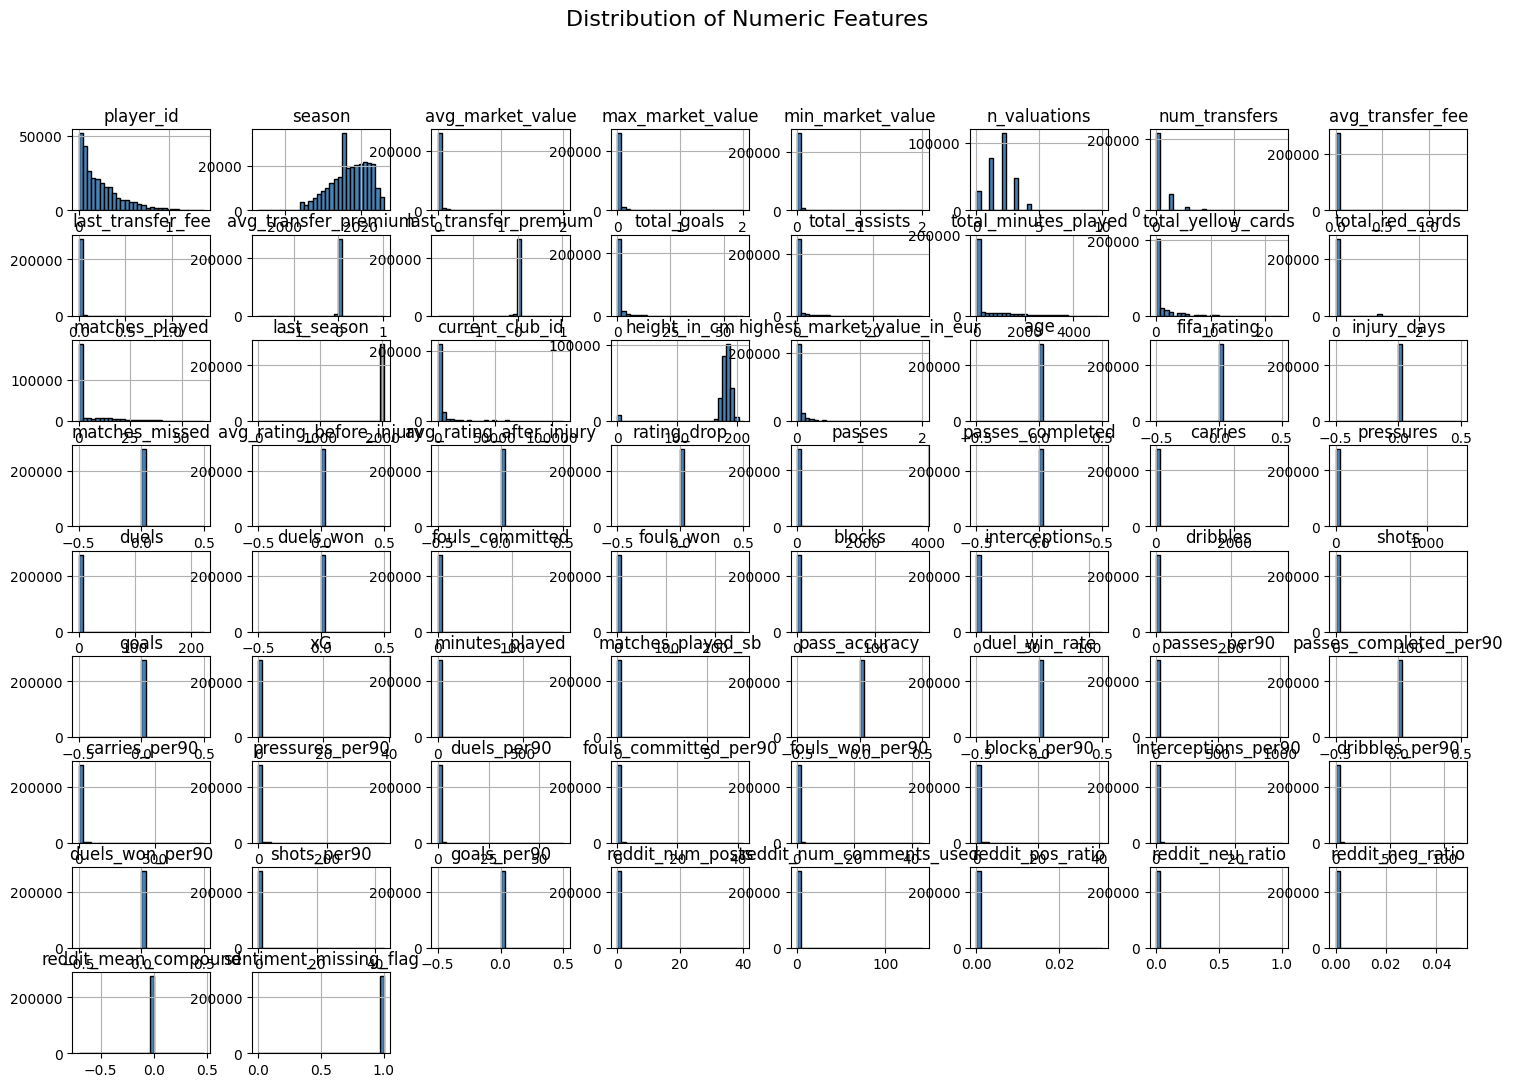

In [5]:
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols].hist(bins=30, figsize=(18, 12), color="steelblue", edgecolor="black")
plt.suptitle("Distribution of Numeric Features", fontsize=16)
plt.show()


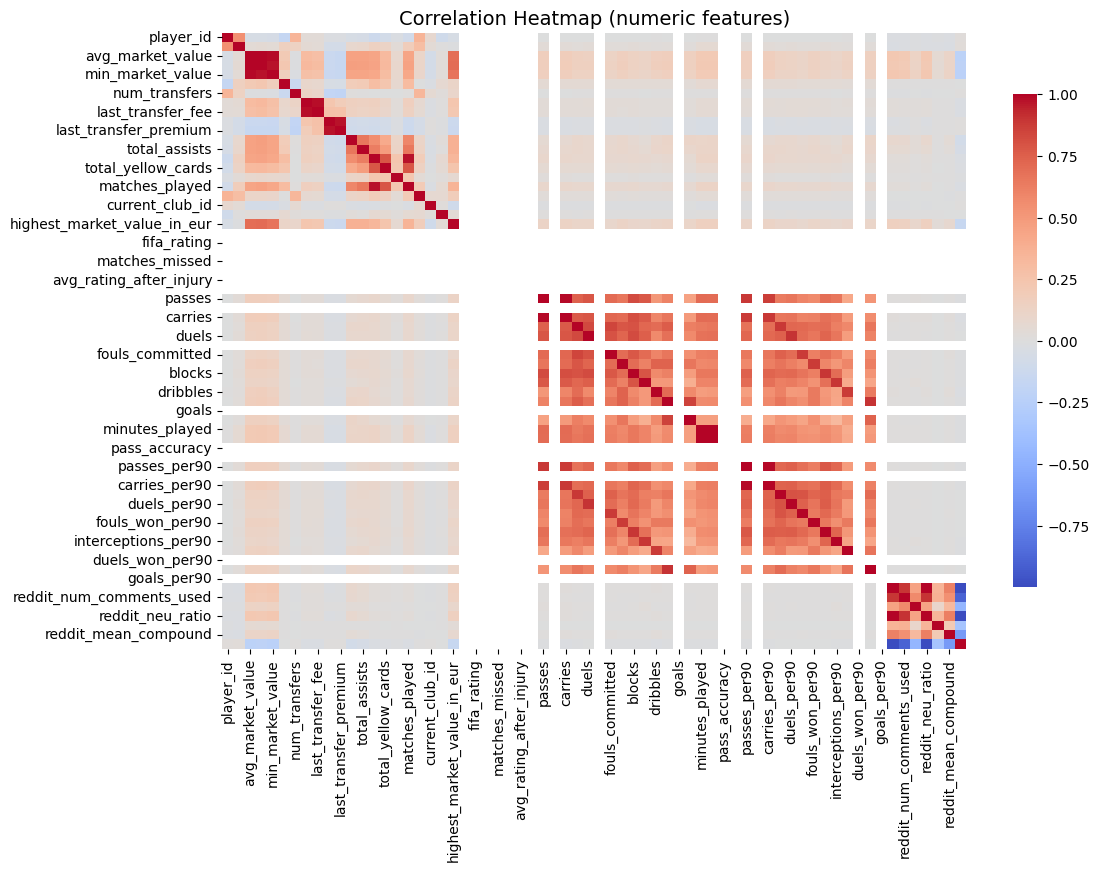

In [6]:
plt.figure(figsize=(12,8))
corr = df[num_cols].corr()
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, cbar_kws={"shrink":0.8})
plt.title("Correlation Heatmap (numeric features)", fontsize=14)
plt.show()


🧹 4A) Prune redundant & sparse columns (based on EDA)

In [7]:
# --- Context ---
# From EDA:
# - Keep ONE market value column as target (avg_market_value) and drop redundant peers to avoid multicollinearity.
# - reddit_subreddits_covered is ~100% missing -> drop.
# - IDs like player_id/current_club_id carry little signal for modeling; we’ll keep player_name/season only for grouping/roll features, not as predictors.

to_drop_redundant = []
if "max_market_value" in df.columns:   to_drop_redundant.append("max_market_value")
if "min_market_value" in df.columns:   to_drop_redundant.append("min_market_value")
if "highest_market_value_in_eur" in df.columns: to_drop_redundant.append("highest_market_value_in_eur")
if "highest_market_value_in_euro" in df.columns: to_drop_redundant.append("highest_market_value_in_euro")  # alt spelling

to_drop_sparse = [c for c in ["reddit_subreddits_covered"] if c in df.columns]

to_drop_ids = [c for c in ["player_id","current_club_id"] if c in df.columns]

cols_to_drop_now = list(dict.fromkeys(to_drop_redundant + to_drop_sparse + to_drop_ids))  # dedupe
df = df.drop(columns=cols_to_drop_now, errors="ignore")

print("Dropped columns:", cols_to_drop_now)
print("Shape after drop:", df.shape)


Dropped columns: ['max_market_value', 'min_market_value', 'highest_market_value_in_eur', 'reddit_subreddits_covered', 'player_id', 'current_club_id']
Shape after drop: (276823, 78)


🔧 4B) Skewness handling: add log1p versions + winsorize heavy-tailed features

In [8]:
# --- Context ---
# Many features (fees/values/minutes/goals) are right-skewed with big outliers (superstars).
# We’ll (a) create log1p() mirrors and (b) winsorize (clip) at the 1st–99th percentile to stabilize training.

import numpy as np

def add_log1p(df, cols):
    cols = [c for c in cols if c in df.columns]
    for c in cols:
        df[f"log1p__{c}"] = np.log1p(pd.to_numeric(df[c], errors="coerce").clip(lower=0))
    return df

def winsorize(df, cols, p_low=0.01, p_high=0.99):
    cols = [c for c in cols if c in df.columns]
    for c in cols:
        x = pd.to_numeric(df[c], errors="coerce")
        lo, hi = x.quantile(p_low), x.quantile(p_high)
        df[f"win__{c}"] = x.clip(lo, hi)
    return df

skew_candidates = [
    "avg_market_value", "last_transfer_fee", "avg_transfer_fee",
    "avg_transfer_premium", "last_transfer_premium",
    "total_minutes_played", "total_goals", "total_assists",
    "passes", "carries", "shots"
]

df = add_log1p(df, skew_candidates)
df = winsorize(df, skew_candidates, p_low=0.01, p_high=0.99)

print("Added log1p__* and win__* features for:", [c for c in skew_candidates if c in df.columns])


Added log1p__* and win__* features for: ['avg_market_value', 'last_transfer_fee', 'avg_transfer_fee', 'avg_transfer_premium', 'last_transfer_premium', 'total_minutes_played', 'total_goals', 'total_assists', 'passes', 'carries', 'shots']


🧪 4C) Compress Reddit sentiment into dense components (keeps both raw + compact)

In [9]:
# --- Context ---
# Reddit features are sparse/correlated. We’ll create two compact features:
#  - sent_strength ≈ overall magnitude
#  - sent_balance  ≈ positive vs negative balance
# This avoids losing signal while reducing noise. We KEEP raw columns too.

for c in ["reddit_pos_ratio","reddit_neg_ratio","reddit_neu_ratio","reddit_mean_compound"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

if set(["reddit_pos_ratio","reddit_neg_ratio","reddit_mean_compound"]).issubset(df.columns):
    df["sent_strength"] = (
        df["reddit_pos_ratio"].abs() +
        df["reddit_neg_ratio"].abs() +
        df["reddit_mean_compound"].abs()
    )

if set(["reddit_pos_ratio","reddit_neg_ratio"]).issubset(df.columns):
    df["sent_balance"] = df["reddit_pos_ratio"] - df["reddit_neg_ratio"]

print("Added sentiment composites:", [c for c in ["sent_strength","sent_balance"] if c in df.columns])


Added sentiment composites: ['sent_strength', 'sent_balance']


🧱 4D) Rebuild the feature builder (adds per-90, injury ratios, premiums, contract)

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class PandasFeatureBuilder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        def div(a,b): return np.where(b==0, np.nan, a/b)

        # Per-90 on TM totals (if present)
        if "total_minutes_played" in X.columns:
            minutes = pd.to_numeric(X["total_minutes_played"], errors="coerce").replace(0, np.nan)
            factor = minutes / 90.0
            for src, name in [
                ("total_goals","goals_per90"),
                ("total_assists","assists_per90"),
                ("shots_on_target","shots_on_target_per90"),
                ("total_yellow_cards","yellow_cards_per90"),
                ("total_red_cards","red_cards_per90")
            ]:
                if src in X.columns:
                    X[name] = div(pd.to_numeric(X[src], errors="coerce"), factor)

        # Injury ratios
        if "matches_played" in X.columns:
            m = pd.to_numeric(X["matches_played"], errors="coerce").replace(0, np.nan)
            if "injury_days" in X.columns:
                X["injury_days_per_match"] = div(pd.to_numeric(X["injury_days"], errors="coerce"), m)
            if "matches_missed" in X.columns:
                X["missed_ratio"] = div(pd.to_numeric(X["matches_missed"], errors="coerce"), m)

        # Sentiment composites (raw names if present)
        for col in ["reddit_pos_ratio","reddit_neg_ratio","reddit_neu_ratio","reddit_mean_compound"]:
            if col in X.columns:
                X[col] = pd.to_numeric(X[col], errors="coerce")
        if set(["reddit_pos_ratio","reddit_neg_ratio"]).issubset(X.columns):
            X["sentiment_net"] = X["reddit_pos_ratio"] - X["reddit_neg_ratio"]
            X["sentiment_intensity"] = X["reddit_pos_ratio"] + X["reddit_neg_ratio"]
        # flag if any sentiment present
        sent_present_cols = [c for c in ["reddit_pos_ratio","reddit_neg_ratio","reddit_neu_ratio","reddit_mean_compound"] if c in X.columns]
        if sent_present_cols:
            X["has_sentiment_data"] = (~X[sent_present_cols].isna().all(axis=1)).astype(int)

        # Contract expiry → days to end
        if "contract_expiration_date" in X.columns:
            dt = pd.to_datetime(X["contract_expiration_date"], errors="coerce")
            today = pd.Timestamp.today().normalize()
            X["days_to_contract_end"] = (dt - today).dt.days

        # Premium ratios
        for fee_col in [c for c in ["avg_transfer_fee","last_transfer_fee"] if c in X.columns]:
            X[fee_col] = pd.to_numeric(X[fee_col], errors="coerce")
        if set(["avg_transfer_premium","avg_transfer_fee"]).issubset(X.columns):
            X["avg_premium_over_fee"] = div(X["avg_transfer_premium"], X["avg_transfer_fee"])
        if set(["last_transfer_premium","last_transfer_fee"]).issubset(X.columns):
            X["last_premium_over_fee"] = div(X["last_transfer_premium"], X["last_transfer_fee"])

        return X

print("Feature builder ready.")


Feature builder ready.


🧮 4E) Rolling, injury decay, contract buckets, and interactions (as separate cell)

In [11]:
# Season order for leakage-safe rolling
import re

def season_to_year(season):
    if pd.isna(season): return np.nan
    s = str(season)
    m = re.search(r"(\d{4})", s)
    if m: return int(m.group(1))
    try: return int(float(s))
    except: return np.nan

df["season_order"] = pd.to_numeric(df["season"].apply(season_to_year), errors="coerce")

# Rolling previous seasons (shift to avoid leakage)
perf_candidates = ["goals_per90","assists_per90","total_minutes_played","total_goals","total_assists","injury_days","matches_played","shots_on_target_per90"]
perf_cols = [c for c in perf_candidates if c in df.columns]

for w in [1, 3]:
    for c in perf_cols:
        df[f"{c}_roll{w}_mean_prev"]  = df.groupby("player_name")[c].transform(lambda s: s.shift(1).rolling(window=w, min_periods=1).mean())
        df[f"{c}_roll{w}_count_prev"] = df.groupby("player_name")[c].transform(lambda s: s.shift(1).rolling(window=w, min_periods=0).count())

# Injury exponential decay (past seasons only)
if "injury_days" in df.columns:
    df["injury_decay_score"] = df.groupby("player_name")["injury_days"].transform(lambda s: s.shift(1).ewm(alpha=0.8, adjust=False).mean()).fillna(0)

# Contract buckets
if "days_to_contract_end" in df.columns:
    x = pd.to_numeric(df["days_to_contract_end"], errors="coerce")
    df["contract_bucket"] = pd.cut(x, bins=[-1e9,183,365,730,1e9], labels=["<6m","6-12m","12-24m",">24m"])

# Sentiment × performance interactions
sent_cols = [c for c in ["sentiment_net","sentiment_intensity","reddit_mean_compound","sent_balance","sent_strength"] if c in df.columns]
perf_interact_cols = [c for c in ["goals_per90","assists_per90","shots_on_target_per90","total_goals","total_assists"] if c in df.columns]

for s in sent_cols:
    for p in perf_interact_cols:
        df[f"{p}_x_{s}"] = pd.to_numeric(df[p], errors="coerce") * pd.to_numeric(df[s], errors="coerce")

print("Added rolling, injury decay, buckets, and sentiment interactions.")


Added rolling, injury decay, buckets, and sentiment interactions.


🧰 4F) Preprocessing pipeline (impute + scale + one-hot) and save artifacts

In [13]:
# Find categorical columns with mixed python types (e.g., int + str)
cat_cols = [c for c in df.columns if df[c].dtype == "object"]

def mixed_types(series):
    vals = series.dropna().values
    if len(vals) == 0:
        return False
    types = {type(v) for v in vals}
    return len(types) > 1

mixed_cat = [c for c in cat_cols if mixed_types(df[c])]
print("Mixed-type categorical columns:", mixed_cat[:20], f"(total {len(mixed_cat)})")

# Optional: force ALL categorical columns to string now (safe)
for c in cat_cols:
    df[c] = df[c].astype(str)


Mixed-type categorical columns: ['reddit_fallback_used'] (total 1)


In [14]:
# Make reddit_fallback_used a clean numeric flag (0/1)
if "reddit_fallback_used" in df.columns:
    df["reddit_fallback_used"] = (
        df["reddit_fallback_used"]
        .map({True: 1, False: 0})      # handle booleans if present
        .astype("float")               # allow NaNs
        .fillna(1.0)                   # default: fallback used when missing
        .astype("int8")                # compact numeric flag
    )


In [15]:
target_col = "avg_market_value" if "avg_market_value" in df.columns else None
id_cols = [c for c in ["player_name","season"] if c in df.columns]
drop_cols = [c for c in (id_cols + ([target_col] if target_col else [])) if c in df.columns]

feature_cols = [c for c in df.columns if c not in drop_cols]
cat_cols = [c for c in feature_cols if df[c].dtype == "object"]
num_cols = [c for c in feature_cols if c not in cat_cols]

print(f"Using target: {target_col}")
print(f"Num cols: {len(num_cols)}  |  Cat cols: {len(cat_cols)}")


Using target: avg_market_value
Num cols: 119  |  Cat cols: 15


In [17]:
from pathlib import Path

# Make sure OUT_DIR is defined
OUT_DIR = Path(PROJECT_PATH) / "Data_Featuring"
OUT_DIR.mkdir(parents=True, exist_ok=True)


In [19]:
# Define paths for augmented features + pipeline
aug_parquet = OUT_DIR / "features_augmented.parquet"
pipe_path   = OUT_DIR / "feature_pipeline.joblib"


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
import joblib

# Target and ID columns
target_col = "avg_market_value" if "avg_market_value" in df.columns else None
id_cols = [c for c in ["player_name","season"] if c in df.columns]
drop_cols = [c for c in (id_cols + ([target_col] if target_col else [])) if c in df.columns]

# Split
feature_cols = [c for c in df.columns if c not in drop_cols]
cat_cols = [c for c in feature_cols if df[c].dtype == "object"]
num_cols = [c for c in feature_cols if c not in cat_cols]

print(f"Using target: {target_col}")
print(f"Num cols: {len(num_cols)}  |  Cat cols: {len(cat_cols)}")

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, min_frequency=0.01)

numeric_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median", add_indicator=True)),
    ("scale", RobustScaler())
])

categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
    ("onehot", encoder)
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
], remainder="drop", verbose_feature_names_out=True)

feature_pipeline = Pipeline([
    ("build_features", PandasFeatureBuilder()),   # safe: will skip if cols missing
    ("preprocess", preprocess)
])

X = df.drop(columns=drop_cols) if drop_cols else df.copy()
Xt = feature_pipeline.fit_transform(X)

feat_names = feature_pipeline.named_steps["preprocess"].get_feature_names_out()
feat_df = pd.DataFrame(Xt, columns=feat_names, index=df.index)

# Save base features
base_parquet = OUT_DIR / "features.parquet"
base_csv = OUT_DIR / "features.csv.gz"

try:
    feat_df.to_parquet(base_parquet, index=False)
    print("Saved:", base_parquet)
except Exception as e:
    feat_df.to_csv(base_csv, index=False, compression="gzip")
    print("Parquet failed, saved CSV instead:", base_csv)

#  Save pipeline
OUT_PIPELINE = OUT_DIR / "feature_pipeline.joblib"
joblib.dump(feature_pipeline, OUT_PIPELINE)

print("Final features shape:", feat_df.shape)

# Augment with newly engineered raw df columns (rolls, interactions, buckets)
new_cols = [c for c in df.columns if ("_roll" in c) or ("injury_decay" in c) or ("contract_bucket" in c) or ("_x_" in c) or (c.startswith("log1p__") or c.startswith("win__"))]
combined = feat_df.join(df[new_cols], how="left")

# High-corr drop (optional audit)
num_only = combined.select_dtypes(include=[np.number])
if num_only.shape[1] > 1:
    corr = num_only.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
else:
    to_drop = []

pd.Series(to_drop).to_csv(OUT_DIR / "high_corr_drop_candidates.csv", index=False)

feat_df_aug = combined.drop(columns=[c for c in to_drop if c in combined.columns], errors="ignore")

# 🔧 Define augmented feature path
aug_parquet = OUT_DIR / "features_augmented.parquet"
pipe_path   = OUT_DIR / "feature_pipeline.joblib"

feat_df_aug.to_parquet(aug_parquet, index=False)

print("Saved:")
print(" - Base features :", base_parquet)
print(" - Aug features  :", aug_parquet)
print(" - Pipeline      :", pipe_path)
print("Shapes → base:", feat_df.shape, "| aug:", feat_df_aug.shape)


Using target: avg_market_value
Num cols: 119  |  Cat cols: 15
Saved: /content/drive/MyDrive/player_value_prediction_project/Data_Featuring/features.parquet
Final features shape: (276823, 226)
Saved:
 - Base features : /content/drive/MyDrive/player_value_prediction_project/Data_Featuring/features.parquet
 - Aug features  : /content/drive/MyDrive/player_value_prediction_project/Data_Featuring/features_augmented.parquet
 - Pipeline      : /content/drive/MyDrive/player_value_prediction_project/Data_Featuring/feature_pipeline.joblib
Shapes → base: (276823, 226) | aug: (276823, 187)
